# Discharge Notes and Readmission Rates: Modeling

This notebook is for the modeling the cleaned dataset.

## Import

In [1]:
import pandas as pd
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
import string
import re
from nltk.stem import WordNetLemmatizer 

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,\
HashingVectorizer
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.dummy import DummyClassifier

#import xgboost as xg
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, plot_confusion_matrix
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
#from imblearn.over_sampling import SMOTENC
#from imblearn.pipeline import Pipeline as imbpipeline

In [2]:
#set the pandas display column width as max to read in all the text
pd.set_option('display.max_colwidth', None)

In [17]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

## Functions

In [3]:
def vectorizing(vectorizer, train, val, test):
    vec_train = vectorizer.fit_transform(train['TEXT'])
    vec_val = vectorizer.transform(val['TEXT'])
    vec_test = vectorizer.transform(test['TEXT'])
    vec_train_df1 = pd.DataFrame(vec_train.todense(),columns=vectorizer.get_feature_names())
    vec_val_df1 = pd.DataFrame(vec_val.todense(),columns=vectorizer.get_feature_names())
    vec_test_df1 = pd.DataFrame(vec_test.todense(),columns=vectorizer.get_feature_names())
    vec_train_df1.reset_index(drop=True, inplace=True)
    vec_val_df1.reset_index(drop=True, inplace=True)
    vec_test_df1.reset_index(drop=True, inplace=True)
    train2 = train.drop('TEXT', axis=1).reset_index(drop=True)
    val2 = val.drop('TEXT', axis=1).reset_index(drop=True)
    test2 = test.drop('TEXT', axis=1).reset_index(drop=True)
    vec_train_df2 = train2.merge(vec_train_df1, left_index=True, right_index=True)
    vec_val_df2 = val2.merge(vec_val_df1, left_index=True, right_index=True)
    vec_test_df2 = test2.merge(vec_test_df1, left_index=True, right_index=True)
    return vec_train_df1, vec_val_df1, vec_test_df1, vec_train_df2, vec_val_df2, vec_test_df2

In [4]:
def scores(model, X, y, set_type):
    pred = model.predict(X)
    
    print("{} Scores".format(set_type))
    print("accuracy: ", accuracy_score(y, pred))
    print("recall:   ", recall_score(y, pred))
    plot_confusion_matrix(model, X, y)

## Reviewing the Data

In [5]:
df = pd.read_csv('data/admissions_cleaned.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45591 entries, 0 to 45590
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ADMISSION_TYPE      45591 non-null  object
 1   ADMISSION_LOCATION  45591 non-null  object
 2   DISCHARGE_LOCATION  45591 non-null  object
 3   INSURANCE           45591 non-null  object
 4   LANGUAGE            45591 non-null  object
 5   RELIGION            45591 non-null  object
 6   MARITAL_STATUS      45591 non-null  object
 7   ETHNICITY           45591 non-null  object
 8   DIAGNOSIS           45591 non-null  object
 9   READMISSION         45591 non-null  int64 
 10  GENDER              45591 non-null  object
 11  AGE                 45591 non-null  int64 
 12  TEXT                45591 non-null  object
 13  CPT_CD              45591 non-null  object
 14  DIAG_ICD9_CODE      45590 non-null  object
 15  DRG_CODE            45591 non-null  object
 16  PROCED_ICD9_CODE    45

In [7]:
sw = stopwords.words('english')

In [8]:
sample_doc = df['TEXT'][0]

In [9]:
sample_doc

"Admission Date:  [**2100-6-7**]              Discharge Date:   [**2100-6-9**]\n\nDate of Birth:  [**2044-4-23**]             Sex:   M\n\nService: MEDICINE\n\nAllergies:\nNo Known Allergies / Adverse Drug Reactions\n\nAttending:[**First Name3 (LF) 2024**]\nChief Complaint:\ndizziness\n\nMajor Surgical or Invasive Procedure:\nNONE\n\n\nHistory of Present Illness:\nHistory of Present Illness: Mr. [**Known lastname 83415**] is a 56 year old male\nwith PMH notable for metastatic cancer (unknown primary)\nundergoing chemo now presenting with lighheadedness and\nhemoptysis. Pt is undergoing chemo with gemcitabine ([**2100-5-24**],\n[**2100-5-31**]) for malignant neoplasm of unknown primary with multiple\nbone, muscle, and soft-tissue metastases. He came to the\nhospital to start RT to L femur today.  Pt reports a couple days\nof lightheadedness, nonpositional.  Pt reports one episode of\nhemoptysis [**2100-6-3**] but none since then. No sig lung lesions on\nchest CT [**2100-5-27**]. Was sche

In [10]:
sample_doc = sample_doc.replace('\n', ' ')
sample_doc = sample_doc.replace('\r', ' ')
sample_doc = sample_doc.lower()
sample_doc

"admission date:  [**2100-6-7**]              discharge date:   [**2100-6-9**]  date of birth:  [**2044-4-23**]             sex:   m  service: medicine  allergies: no known allergies / adverse drug reactions  attending:[**first name3 (lf) 2024**] chief complaint: dizziness  major surgical or invasive procedure: none   history of present illness: history of present illness: mr. [**known lastname 83415**] is a 56 year old male with pmh notable for metastatic cancer (unknown primary) undergoing chemo now presenting with lighheadedness and hemoptysis. pt is undergoing chemo with gemcitabine ([**2100-5-24**], [**2100-5-31**]) for malignant neoplasm of unknown primary with multiple bone, muscle, and soft-tissue metastases. he came to the hospital to start rt to l femur today.  pt reports a couple days of lightheadedness, nonpositional.  pt reports one episode of hemoptysis [**2100-6-3**] but none since then. no sig lung lesions on chest ct [**2100-5-27**]. was scheduled to have transfusion o

In [11]:
punc = string.punctuation
num = "0123456789"
punc_num = punc + num
for i in list(punc_num):
    sample_doc = sample_doc.replace(i, ' ')

## Train and Test Split

In [12]:
X = df.drop('READMISSION', axis=1)
y = df['READMISSION']

In [13]:
X_train, X_v_t, y_train, y_v_t = train_test_split(X, y, test_size=0.40, random_state=42, stratify=y)

In [14]:
X_val, X_test, y_val, y_test = train_test_split(X_v_t, y_v_t, test_size=0.50, random_state=42, stratify=y_v_t)

## Pipeline Parameters

### Vectorizer Parameters

In [ ]:
pattern=r"([a-zA-Z]+(?:'[a-z]+)?)"
sw = stopwords.words('english')
max_features = 3000

### Preprocessing Parameters

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45591 entries, 0 to 45590
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ADMISSION_TYPE      45591 non-null  object
 1   ADMISSION_LOCATION  45591 non-null  object
 2   DISCHARGE_LOCATION  45591 non-null  object
 3   INSURANCE           45591 non-null  object
 4   LANGUAGE            45591 non-null  object
 5   RELIGION            45591 non-null  object
 6   MARITAL_STATUS      45591 non-null  object
 7   ETHNICITY           45591 non-null  object
 8   DIAGNOSIS           45591 non-null  object
 9   READMISSION         45591 non-null  int64 
 10  GENDER              45591 non-null  object
 11  AGE                 45591 non-null  int64 
 12  TEXT                45591 non-null  object
 13  CPT_CD              45591 non-null  object
 14  DIAG_ICD9_CODE      45590 non-null  object
 15  DRG_CODE            45591 non-null  object
 16  PROCED_ICD9_CODE    45

In [28]:
X_num = ['AGE']
X_cat = df.drop(['AGE', 'READMISSION', 'TEXT'], axis=1).columns

In [29]:
numTrans = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])
catTrans = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse=False,
                          handle_unknown='ignore'))
    ])

c_transform = ColumnTransformer(transformers=[
    ('num', numTrans, X_num),
    ('cat', catTrans, X_cat)
    ])

## Vectorizing Text Data

In [15]:
pattern=r"([a-zA-Z]+(?:'[a-z]+)?)"
sw = stopwords.words('english')
max_features = 3000

### Count Vectorizer

In [18]:
countvec = CountVectorizer(stop_words=sw, token_pattern=pattern, max_features=max_features, tokenizer=LemmaTokenizer())

In [19]:
count_train_1, count_val_1, count_test_1, count_train_2, count_val_2, count_test_2 = vectorizing(countvec, X_train, X_val, X_test)

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


### TFIDF Vectorizer

In [20]:
tfvec = TfidfVectorizer(stop_words=sw, token_pattern=pattern, max_features=max_features)

In [21]:
tfidf_train_1, tfidf_val_1, tfidf_test_1, tfidf_train_2, tfidf_val_2, tfidf_test_2 = vectorizing(tfvec, X_train, X_val, X_test)

In [36]:
tfidf_train_2

,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,GENDER,...,yeast,yellow,yesterday,yet,yo,yrs,zantac,zocor,zofran,zosyn
0,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,UNKNOWN,JEWISH,UNKNOWN,WHITE,NEWBORN,M,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,UNKNOWN,PROTESTANT QUAKER,SINGLE,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE;CHRONIC OBST PULM DISEASE,M,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2,EMERGENCY,CLINIC REFERRAL/PREMATURE,SNF,Medicare,CAPE,CATHOLIC,DIVORCED,MULTI RACE ETHNICITY,PNEUMONIA,M,...,0.000000,0.000000,0.000000,0.0,0.014342,0.000000,0.0,0.0,0.024782,0.000000
3,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,UNKNOWN,UNOBTAINABLE,MARRIED,WHITE,SUBDURAL HEMATOMA,M,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,UNKNOWN,UNOBTAINABLE,UNKNOWN,BLACK/AFRICAN AMERICAN,FEVER-CHEST PAIN,F,...,0.026311,0.027317,0.000000,0.0,0.020158,0.000000,0.0,0.0,0.000000,0.027533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27349,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicaid,THAI,BUDDHIST,MARRIED,ASIAN,UPPER GI BLEED,F,...,0.000000,0.000000,0.000000,0.0,0.048280,0.000000,0.0,0.0,0.000000,0.000000
27350,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,UNKNOWN,UNABLE TO OBTAIN,ATRIAL DEFECT\REPAIR PATENT FORAMEN OVALE/SDA,M,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
27351,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,PROTESTANT QUAKER,MARRIED,WHITE,CEREBELLAR TUMOR/SDA,F,...,0.000000,0.000000,0.000000,0.0,0.000000,0.085071,0.0,0.0,0.000000,0.000000
27352,EMERGENCY,CLINIC REFERRAL/PREMATURE,SNF,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,LIVER HEMORRHAGE,M,...,0.000000,0.000000,0.032416,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000


### HashingVectorizer

In [20]:
#hashvec = HashingVectorizer(stop_words=sw, token_pattern=pattern, n_features=max_features)

In [21]:
#hash_train_df1, hash_val_df1, hash_test_df1, hash_train_df2, hash_val_df2, hash_test_df2 = vectorizing(hashvec, X_train, X_val, X_test)

## Pipeline Parameters

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45591 entries, 0 to 45590
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ADMISSION_TYPE      45591 non-null  object
 1   ADMISSION_LOCATION  45591 non-null  object
 2   DISCHARGE_LOCATION  45591 non-null  object
 3   INSURANCE           45591 non-null  object
 4   LANGUAGE            45591 non-null  object
 5   RELIGION            45591 non-null  object
 6   MARITAL_STATUS      45591 non-null  object
 7   ETHNICITY           45591 non-null  object
 8   DIAGNOSIS           45591 non-null  object
 9   READMISSION         45591 non-null  int64 
 10  GENDER              45591 non-null  object
 11  AGE                 45591 non-null  int64 
 12  TEXT                45591 non-null  object
 13  CPT_CD              45591 non-null  object
 14  DIAG_ICD9_CODE      45590 non-null  object
 15  DRG_CODE            45591 non-null  object
 16  PROCED_ICD9_CODE    45

In [28]:
X_num = ['AGE']
X_cat = df.drop(['AGE', 'READMISSION', 'TEXT'], axis=1).columns

In [29]:
numTrans = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])
catTrans = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse=False,
                          handle_unknown='ignore'))
    ])

pp = ColumnTransformer(transformers=[
    ('num', numTrans, X_num),
    ('cat', catTrans, X_cat)
    ])

In [25]:
count_train_2_scaled = pp.fit_transform(count_train_2)
count_val_2_scaled = pp.transform(count_val_2)
count_test_2_scaled = pp.transform(count_test_2)

In [38]:
tfidf_train_2_scaled.shape

(27354, 66544)

In [26]:
tfidf_train_2_scaled = pp.fit_transform(count_train_2)
tfidf_val_2_scaled = pp.transform(tfidf_val_2)
tfidf_test_2_scaled = pp.transform(tfidf_test_2)

RuntimeError: Given feature/column names do not match the ones for the data given during fit.

## Modeling

### Model 0.1: Dummy Classification - Only Text Data

In [ ]:
pp = Pipeline(steps=[
    
    ('ctrans', c_transform()),
    
    ])

Train Scores
accuracy:  0.6197996636689332
recall:    0.263393481605819
Validation Scores
accuracy:  0.6178986619872779
recall:    0.2677297524129249
Test Scores
accuracy:  0.6224366706875754
recall:    0.28451531682752834


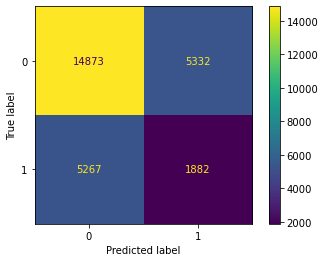

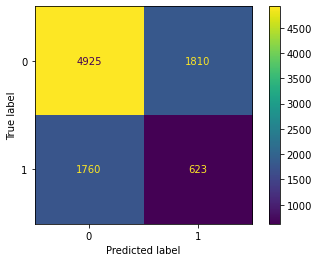

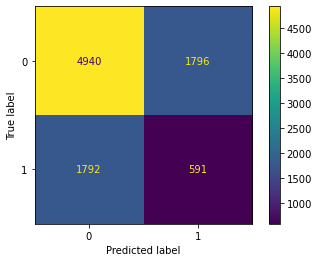

In [30]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(count_train_1, y_train)

scores(dummy_clf, count_train_1, y_train, 'Train')
scores(dummy_clf, count_val_1, y_val, 'Validation')
scores(dummy_clf, count_test_1, y_test, 'Test')

Train Scores
accuracy:  0.6141332163486145
recall:    0.2657714365645545
Validation Scores
accuracy:  0.6151568326387366
recall:    0.2555602182123374
Test Scores
accuracy:  0.620353108893519
recall:    0.2723457826269408


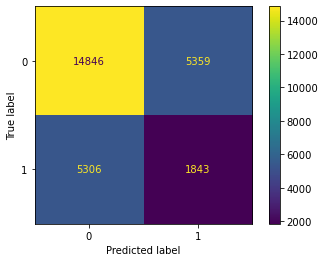

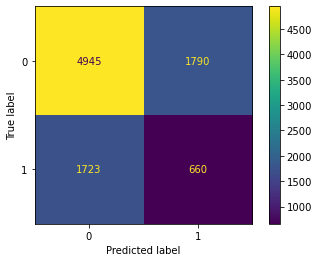

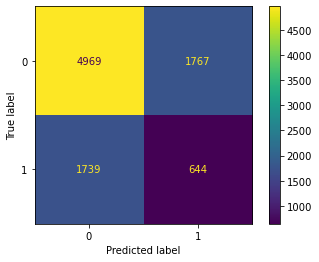

In [31]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(tfidf_train_1, y_train)

scores(dummy_clf, tfidf_train_1, y_train, 'Train')
scores(dummy_clf, tfidf_val_1, y_val, 'Validation')
scores(dummy_clf, tfidf_test_1, y_test, 'Test')

### Model 0.2: Dummy Classification - Text + Additional Features

Train Scores
accuracy:  0.6138773122760839
recall:    0.26493215834382433
Validation Scores
accuracy:  0.6146084667690282
recall:    0.2614351657574486
Test Scores
accuracy:  0.6164053075995175
recall:    0.26017624842635334


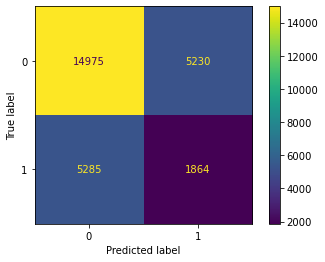

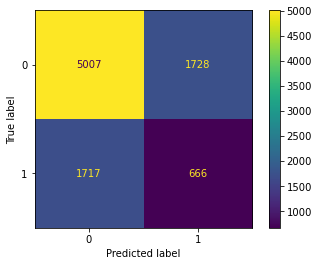

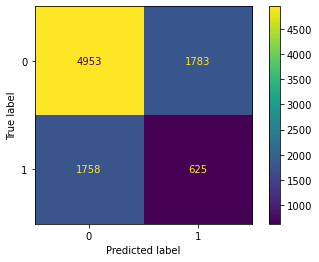

In [30]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(count_train_2_scaled, y_train)

scores(dummy_clf, count_train_2_scaled, y_train, 'Train')
scores(dummy_clf, count_val_2_scaled, y_val, 'Validation')
scores(dummy_clf, count_test_2_scaled, y_test, 'Test')

Train Scores
accuracy:  0.6158514294070337
recall:    0.2624143236816338
Validation Scores
accuracy:  0.6160342180302698
recall:    0.2618548048678137
Test Scores
accuracy:  0.6098256387761816
recall:    0.25346202266051193


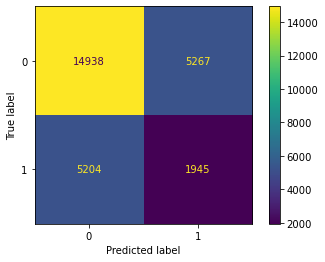

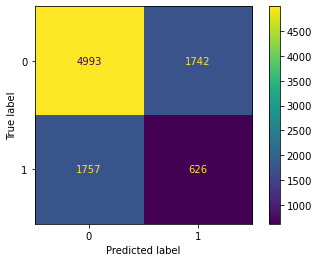

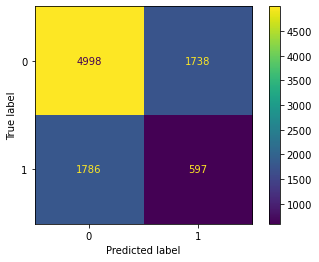

In [31]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(tfidf_train_2_scaled, y_train)

scores(dummy_clf, tfidf_train_2_scaled, y_train, 'Train')
scores(dummy_clf, tfidf_val_2_scaled, y_val, 'Validation')
scores(dummy_clf, tfidf_test_2_scaled, y_test, 'Test')

### Model 1.1: Logistic Regression - Only Text Data

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Scores
accuracy:  0.8043064999634423
recall:    0.4498531263113722
Validation Scores
accuracy:  0.7931563939460408
recall:    0.43054972723457824
Test Scores
accuracy:  0.7864897466827503
recall:    0.4208980276961813


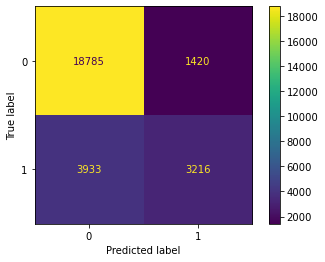

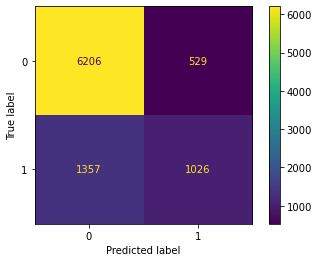

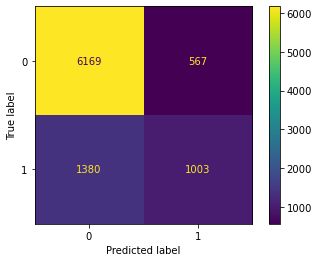

In [40]:
logreg = LogisticRegression(random_state=42)
logreg.fit(count_train_1, y_train)

scores(logreg, count_train_1, y_train, 'Train')
scores(logreg, count_val_1, y_val, 'Validation')
scores(logreg, count_test_1, y_test, 'Test')

In [43]:
output = logreg.predict(count_train_1)

In [44]:
output.shape

(27354,)

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Scores
accuracy:  0.8206478028807487
recall:    0.4593649461463142
Validation Scores
accuracy:  0.7983110331212986
recall:    0.4221569450272765
Test Scores
accuracy:  0.8012940015352561
recall:    0.4385228703315149


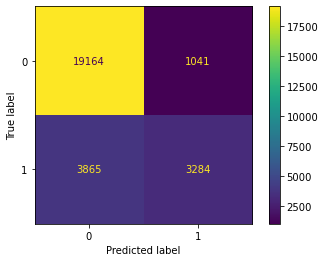

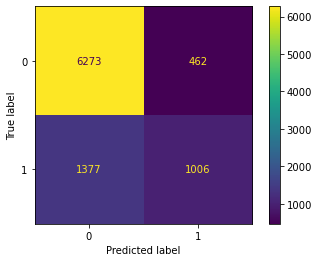

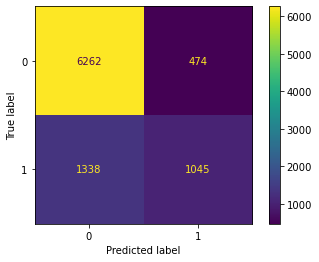

In [33]:
logreg = LogisticRegression(random_state=42)
logreg.fit(tfidf_train_1, y_train)

scores(logreg, tfidf_train_1, y_train, 'Train')
scores(logreg, tfidf_val_1, y_val, 'Validation')
scores(logreg, tfidf_test_1, y_test, 'Test')

### Model 1.2: Logistic Regression - Text + Additional Features

In [34]:
logreg = LogisticRegression(random_state=42)
logreg.fit(count_train_2_scaled, y_train)

scores(logreg, count_train_2_scaled, y_train, 'Train')
scores(logreg, count_val_2_scaled, y_val, 'Validation')
scores(logreg, count_test_2_scaled, y_test, 'Test')

KeyboardInterrupt: 

In [ ]:
logreg = LogisticRegression(random_state=42)
logreg.fit(tfidf_train_2_scaled, y_train)

scores(logreg, tfidf_train_2_scaled, y_train, 'Train')
scores(logreg, tfidf_val_2_scaled, y_val, 'Validation')
scores(logreg, tfidf_test_2_scaled, y_test, 'Test')

### Model 2: K-Nearest Neighbors

### Model 3: Decision Tree Model

### Model 4: Random Forest

### Model 5: XGBoost

### Model 6: AdaBoost

### Model 7: Gradient Boost

### Model 8: Neural Network

### Model 9: Convolutional Neural Network